<a href="https://colab.research.google.com/github/myy04/Real-Fake-Image-Classifier/blob/main/CLIP_classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoModel, AutoProcessor
import os
import torchvision
import torchvision.transforms as transforms
from torch import Tensor

import warnings
warnings.filterwarnings("ignore")

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [5]:
class ImageDataset(Dataset):
    def __init__(self, path):

        real_images_directory = os.path.join(path, 'REAL')
        fake_images_directory = os.path.join(path, 'FAKE')

        real_images = []
        fake_images = []

        for file in os.listdir(real_images_directory):
            real_images.append(os.path.join(real_images_directory, file))

        for file in os.listdir(fake_images_directory):
            fake_images.append(os.path.join(fake_images_directory, file))

        self.images = []
        for i in range(min(len(real_images), len(fake_images))):
            self.images.append((real_images[i], torch.tensor([1, 0], dtype = torch.float32)))
            self.images.append((fake_images[i], torch.tensor([0, 1], dtype = torch.float32)))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx][0]

        return Image.open(image_path).convert("RGB"), self.images[idx][1]



eval_dataset = ImageDataset(os.path.join(path, 'test'))



['a photo of a real Airplane', 'a photo of a real Automobile', 'a photo of a real Bird', 'a photo of a real Cat', 'a photo of a real Deer', 'a photo of a real Dog', 'a photo of a real Frog', 'a photo of a real Horse', 'a photo of a real Ship', 'a photo of a real Truck', 'a generated photo of a Airplane', 'a generated photo of a Automobile', 'a generated photo of a Bird', 'a generated photo of a Cat', 'a generated photo of a Deer', 'a generated photo of a Dog', 'a generated photo of a Frog', 'a generated photo of a Horse', 'a generated photo of a Ship', 'a generated photo of a Truck']


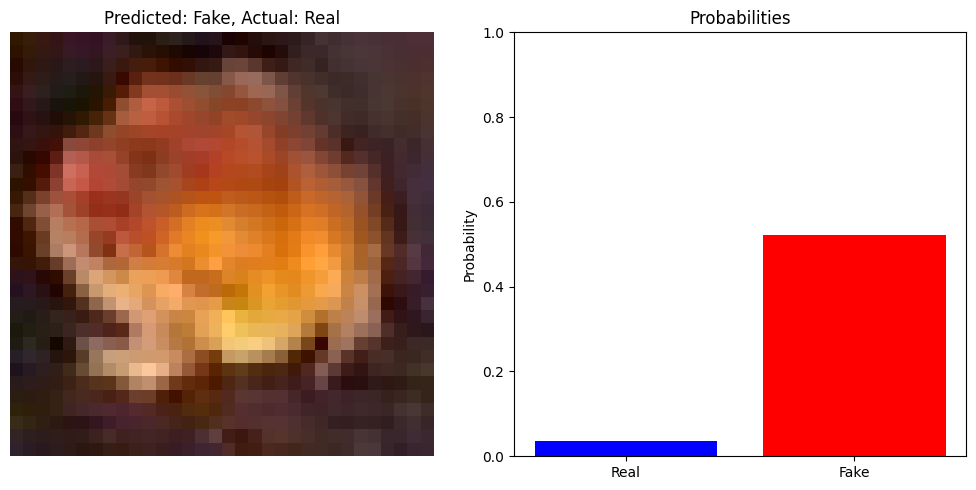

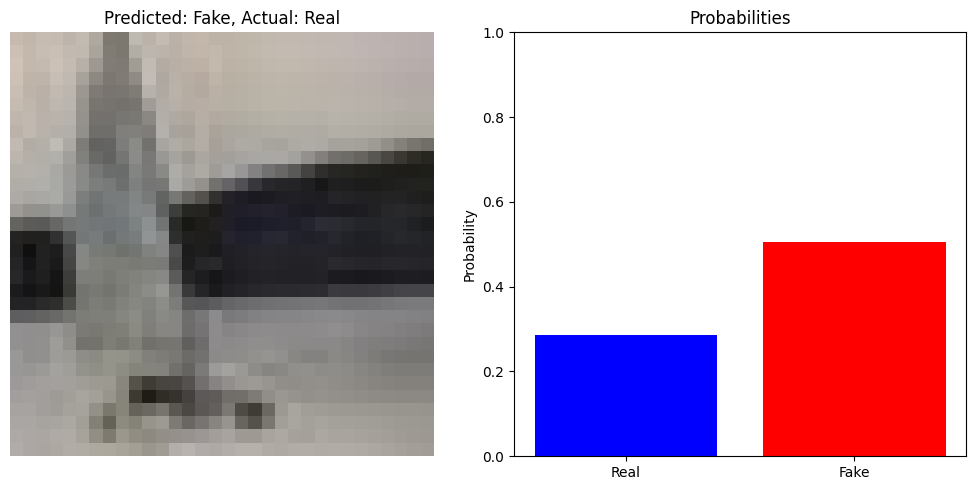

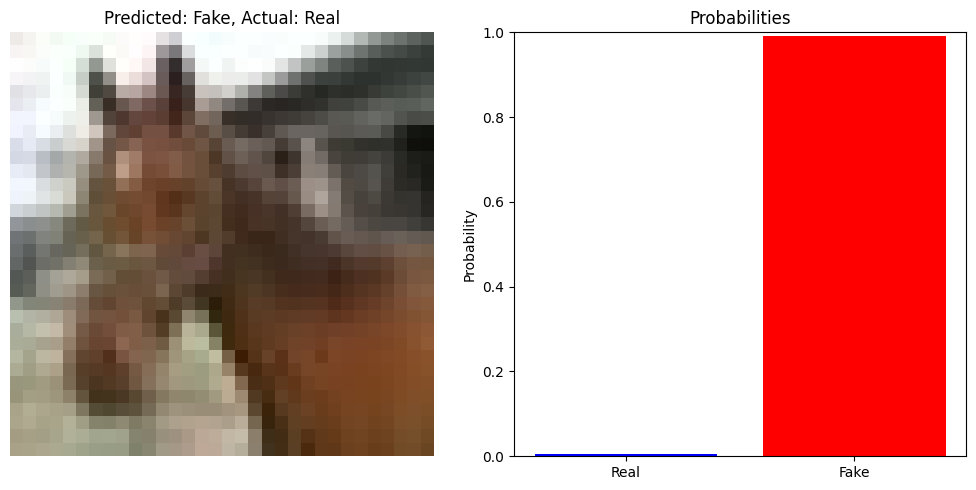

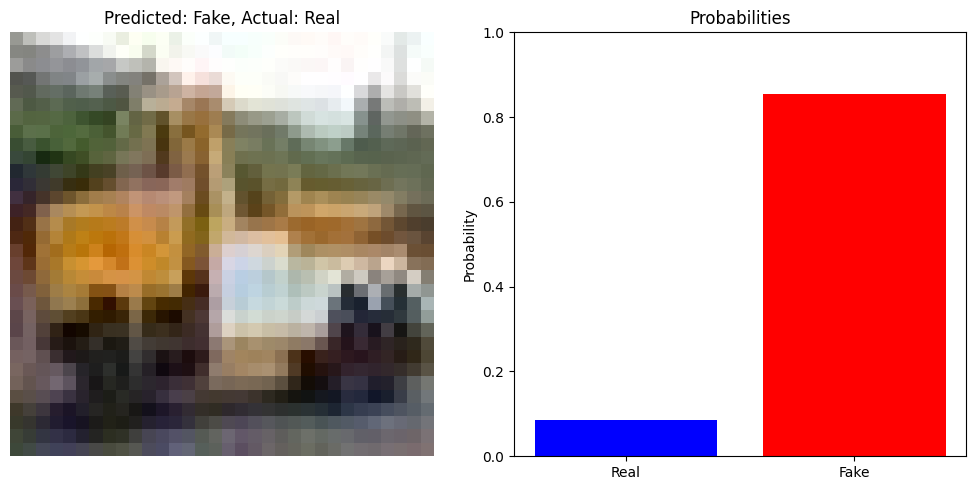

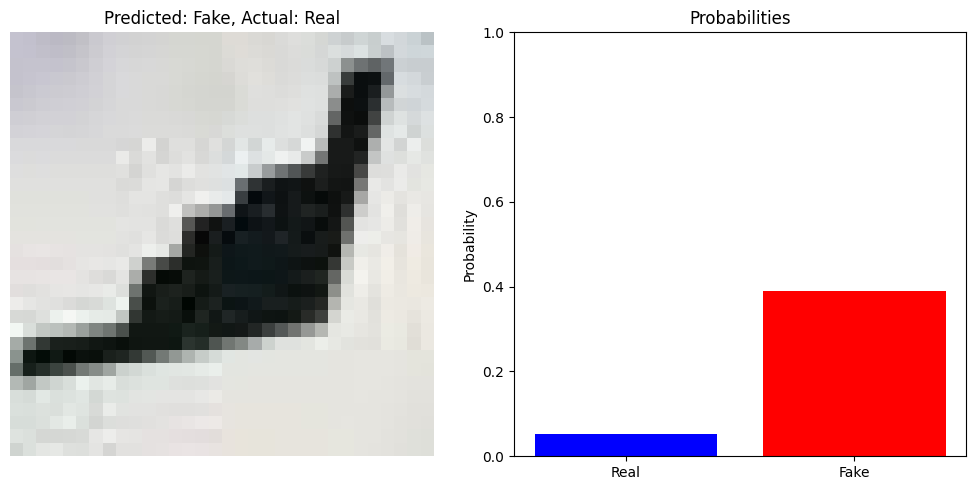

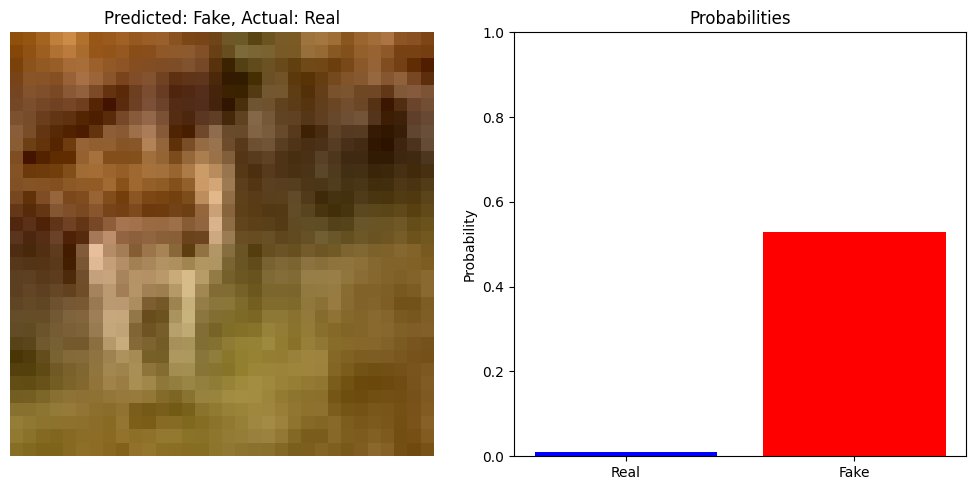

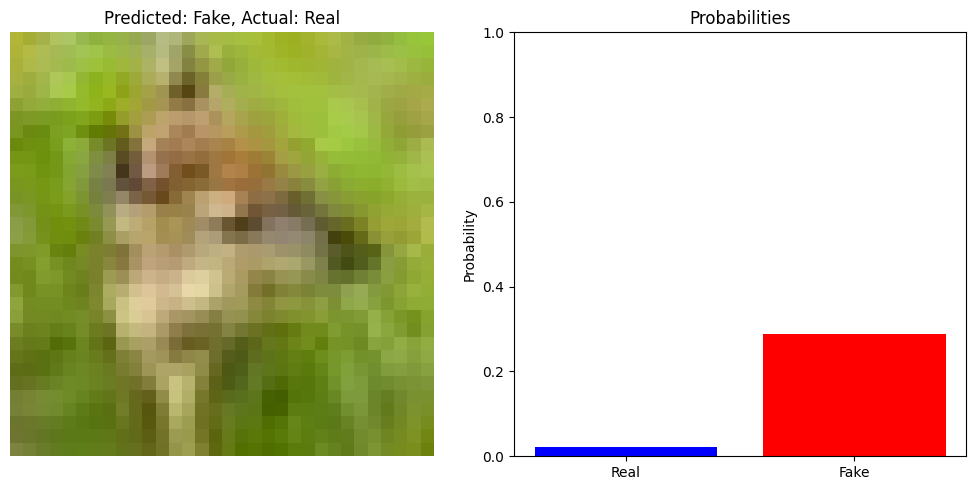

Accuracy: 52.1
Precision: 0.52
Recall: 0.98
F1 Score: 0.68


In [6]:
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")

num_of_correct = 0
total = 0

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

text = []
text += [f"a photo of a real {label}" for label in labels]
text += [f"a generated photo of a {label}" for label in labels]

print(text)


all_predicted_labels = []
all_true_labels = []

for timer in range(0, 1000):
    i = random.randint(0, len(eval_dataset) - 1)

    image, label = eval_dataset.__getitem__(i)

    inputs = clip_processor(text=text, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    probs = [probs[0, :len(labels)].max().item(), probs[0, len(labels):].max().item()]

    predicted_class = torch.tensor(probs).argmax().item()

    correct_prediction = (predicted_class == torch.argmax(label, dim=0).item())

    total += 1
    if correct_prediction:
        num_of_correct += 1

    all_predicted_labels.append(predicted_class)
    all_true_labels.append(torch.argmax(label, dim=0).item())

    if i % 100 == 0:
      # Visualization for each image
      plt.figure(figsize=(10, 5))  # Adjust figure size if needed

      # Subplot 1: Image
      plt.subplot(1, 2, 1)
      plt.imshow(image)
      plt.title(f"Predicted: {'Fake' if predicted_class else 'Real'}, Actual: {'Fake' if label[1].item() else 'Real'}")
      plt.axis('off')

      # Subplot 2: Bar plot
      plt.subplot(1, 2, 2)
      categories = ['Real', 'Fake']
      plt.bar(categories, probs, color=['blue', 'red'])
      plt.title('Probabilities')
      plt.ylabel('Probability')
      plt.ylim([0, 1])  # Set y-axis limits

      plt.tight_layout()  # Adjust layout for better spacing
      plt.show()


precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f'Accuracy: {num_of_correct / total * 100}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


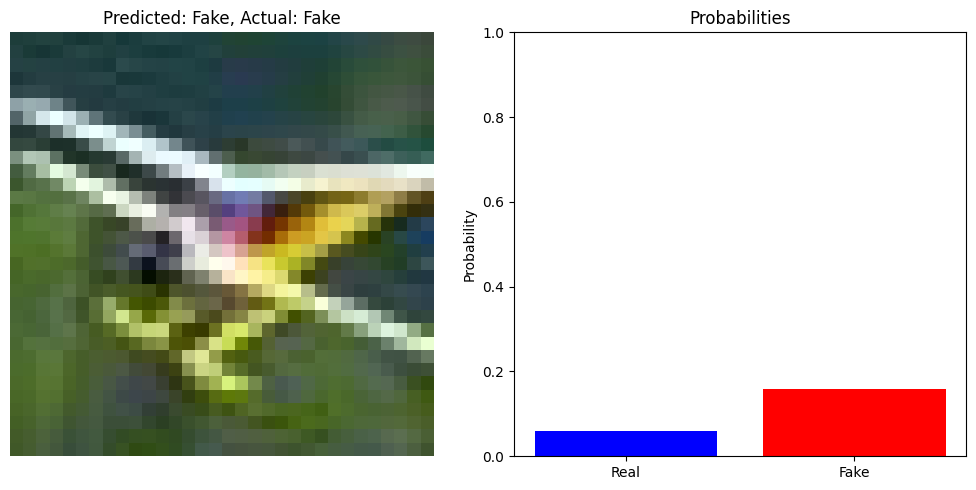

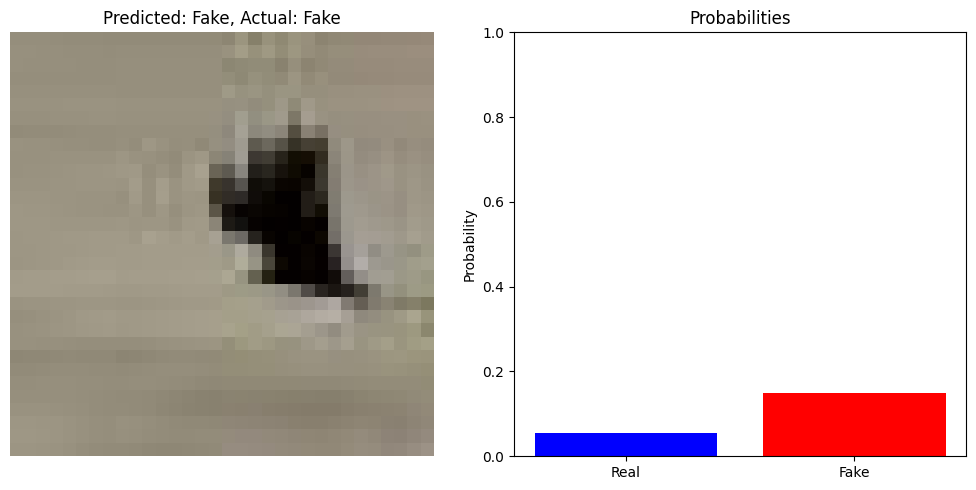

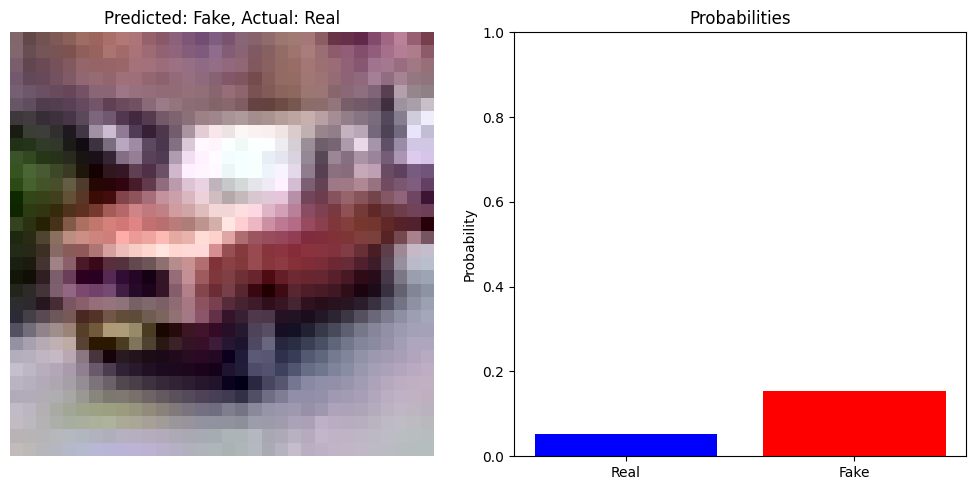

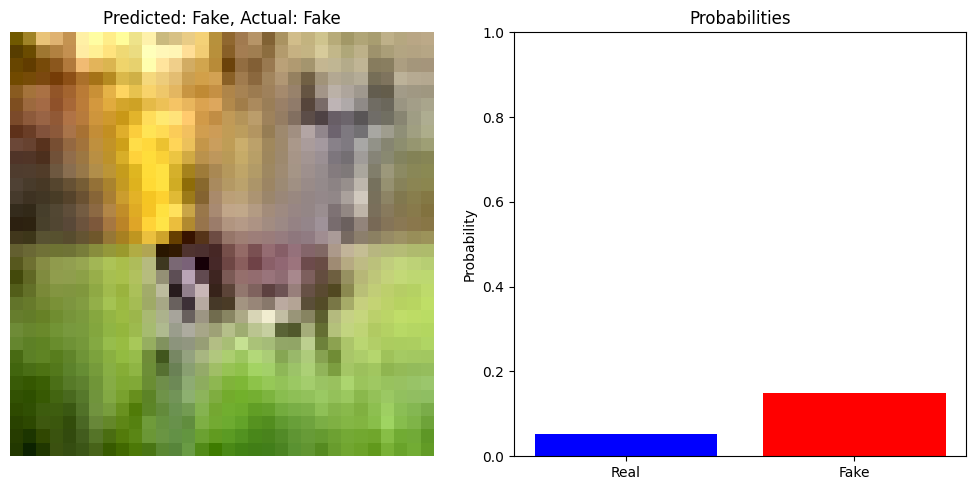

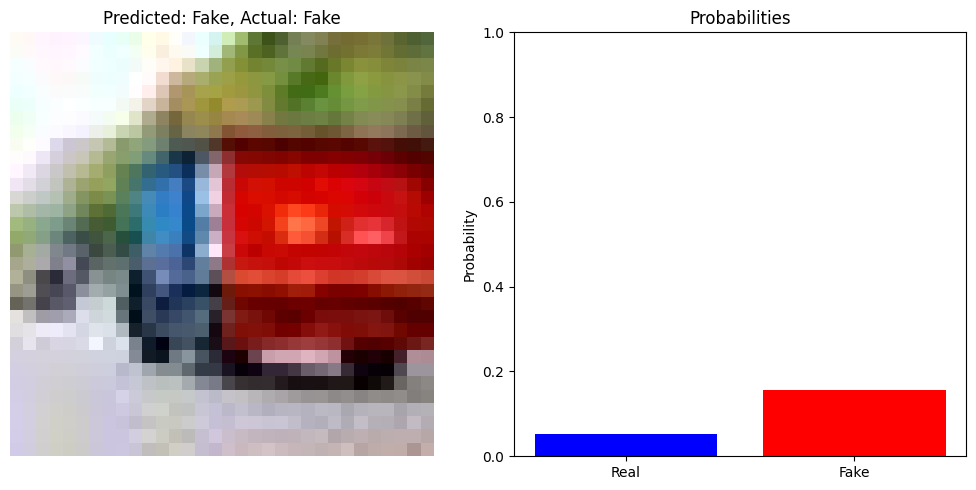

Accuracy: 50.0
Precision: 0.50
Recall: 1.00
F1 Score: 0.67


In [15]:
!pip install scikit-learn matplotlib
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoModel, AutoProcessor
import os
import torchvision
import torchvision.transforms as transforms
from torch import Tensor

import warnings
warnings.filterwarnings("ignore")

import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

# Apply transforms to convert PIL Image to Tensor
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
])

# Update the ImageDataset class to use the transform
class ImageDataset(Dataset):
    def __init__(self, path, transform=None):

        real_images_directory = os.path.join(path, 'REAL')
        fake_images_directory = os.path.join(path, 'FAKE')

        real_images = []
        fake_images = []

        for file in os.listdir(real_images_directory):
            real_images.append(os.path.join(real_images_directory, file))

        for file in os.listdir(fake_images_directory):
            fake_images.append(os.path.join(fake_images_directory, file))

        self.images = []
        for i in range(min(len(real_images), len(fake_images))):
            self.images.append((real_images[i], torch.tensor([1, 0], dtype = torch.float32)))
            self.images.append((fake_images[i], torch.tensor([0, 1], dtype = torch.float32)))

        self.transform = transform # Store the transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx][0]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image) # Apply transform if provided

        return image, self.images[idx][1]

transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization to ImageNet stats
])


# Create the dataset instance with the transform
eval_dataset = ImageDataset(os.path.join(path, 'test'), transform=transform)


clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

text = []
text += [f"a photo of a genuine {label}" for label in labels]  # More specific for real
text += [f"a digitally generated image of a {label}" for label in labels]  # More specific for fake

# Create DataLoader for batch processing
batch_size = 32  # You can adjust the batch size
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

all_predicted_labels = []
all_true_labels = []
num_of_correct = 0
total = 0

# Iterate over batches
for batch_idx, (images, labels_batch) in enumerate(eval_loader):
    # Process the batch of images
    inputs = clip_processor(text=text, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    # Get predicted classes for the batch
    probs_batch = [probs[:, :len(labels)].max(dim=1).values, probs[:, len(labels):].max(dim=1).values]
    predicted_classes_batch = torch.stack(probs_batch).argmax(dim=0)

    # Update counts and store labels for metrics calculation
    total += labels_batch.shape[0]
    num_of_correct += (predicted_classes_batch == labels_batch.argmax(dim=1)).sum().item()
    all_predicted_labels.extend(predicted_classes_batch.tolist())
    all_true_labels.extend(labels_batch.argmax(dim=1).tolist())

    # Visualization for the first image in the batch (optional)
    if batch_idx == 0:  # Visualize only the first batch
        for i in range(min(batch_size, 5)):  # Visualize up to 5 images
            image = images[i]
            predicted_class = predicted_classes_batch[i].item()
            true_label = labels_batch[i].argmax(dim=0).item()
            probs_image = [probs[i, :len(labels)].max().item(), probs[i, len(labels):].max().item()]

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(image.permute(1, 2, 0)) # Permute to (H, W, C) for displaying with plt.imshow
            plt.title(f"Predicted: {'Fake' if predicted_class else 'Real'}, Actual: {'Fake' if true_label else 'Real'}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            categories = ['Real', 'Fake']
            plt.bar(categories, probs_image, color=['blue', 'red'])
            plt.title('Probabilities')
            plt.ylabel('Probability')
            plt.ylim([0, 1])

            plt.tight_layout()
            plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f'Accuracy: {num_of_correct / total * 100}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')